# CS146 Assigment 2: Call center data modeling
# Prof. Scheffler
# Oscar Engelbrektson, Fall 2019

## Loading the data

In [68]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt

%matplotlib inline

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2]
Sum of data set: 1441.6838153800093


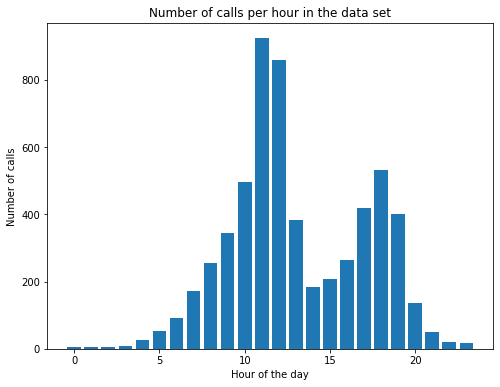

In [69]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('/Users/oscarengelbrektson/Downloads/call_center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:3])
print('Sum of data set:', sum(waiting_times_day))

# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

# Plot the number of calls per hour using a bar chart
plt.figure(figsize=(8, 6))
plt.bar(range(24), [len(w) for w in waiting_times_per_hour])
plt.xlabel('Hour of the day')
plt.ylabel('Number of calls')
plt.title('Number of calls per hour in the data set')
plt.show()

## Plot a histogram of the call wait times for hour 9

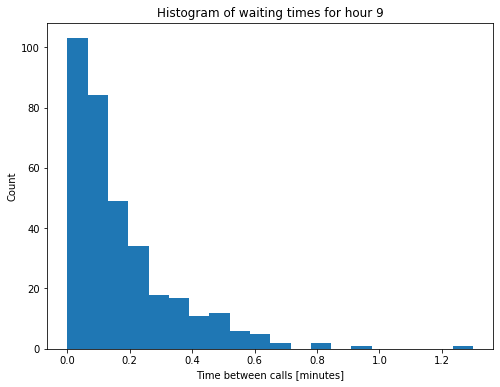

In [70]:
# Plot histogram of waiting times for one hour
hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Count')
plt.title(f'Histogram of waiting times for hour {hour_index}')
plt.show()

## Guess a plausible likelihood function

* The histogram above looks a lot like an instance of the exponential distribution.
* The exponential distribution has 1 parameter, namely the rate $\lambda.$
* A good initial guess for the rate (called the _maximum likelihood estimate_) is the average of the data.
* Note that the maximum likelihood estimate does not give us any information about how much uncertainty there is in our guess for $\lambda$. This is a common problem.

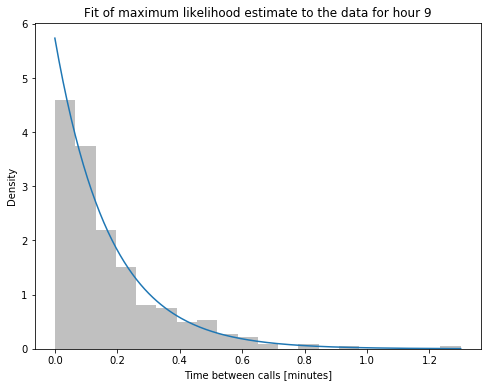

In [71]:
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

## Task 1: Fit an exponential distribution to the data for hour 9

1. We do Bayesian inference on this problem
2. Use the **exponential distribution** as your **likelihood function**. You need to fill in the `likelihood` function below.
3. Use a **gamma distribution** with parameters $\alpha=1$ and $\beta=0.25$ as your **prior**. You need to fill in the `prior` function below.
4. **Compute the posterior distribution over $\lambda$.**
5. **Plot the prior and posterior** distributions on the same axes.

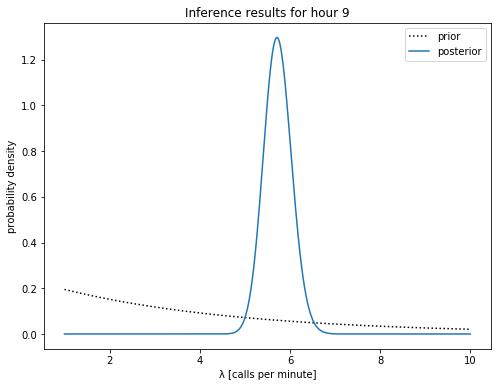

In [75]:
# THE LIKELIHOOD FUNCTION
#
# This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value.

def likelihood(lambda_, datum):
    return sts.expon.pdf(datum, scale=1/lambda_)

# THE PRIOR DISTRIBUTION
#
# This function takes 1 input, namely the parameter value (λ) at which to
# compute the prior probability density. You need to evaluate the distribution
# Gamma(λ | α, β).

def prior(lambda_):
    alpha = 1
    beta = 0.25
    return sts.gamma.pdf(lambda_, a=alpha, scale=1/beta)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

lambdas = np.linspace(1, 10, 500)  # YOU NEED TO COMPLETE THIS.
posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()

## Task 2: Summarize your results

1. **Compute a 98% confidence interval** over the posterior $\lambda$. Use the code provided below to help you.
2. **Discuss** the width of the confidence interval. How certain are we about the call rate during this hour of the day?


In [42]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

print('Lower bound:', compute_percentile(lambdas, posterior, 0.01))
print('Upper bound:', compute_percentile(lambdas, posterior, 0.99))

Lower bound: 4.967935871743487
Upper bound: 6.356713426853707


The lower bound of the 98% confidence interval is 4.97, the upper bound 6.36. This means that whilst we are not certain about the call rate during this hour of the day, we practically certain – 98% confident, to be exact – that the call rate is inside the confidence interval. Speaking loosely, we could say the call rate for the 9th hour of the day will be 5.65+-0.7 (this may be easier to understand for someone who is not all thar familar with statistics).

In [112]:
ci = [4.967935871743487, 6.356713426853707]

#Mean
print(np.mean(ci))

#Bound distance from mean
print(np.mean(ci)-ci[0])

5.662324649298597
0.6943887775551101


## Task 3: Model every hour of the day

### Evaluate if the exponential distribution is an appropriate choice to model the likelihood for each hour
Here I will be looking out for anything that would indicate the exponential distribution is a poor modelling choice, e.g. a multimodal distribution 

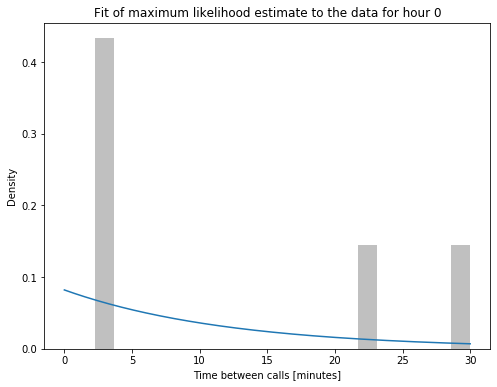

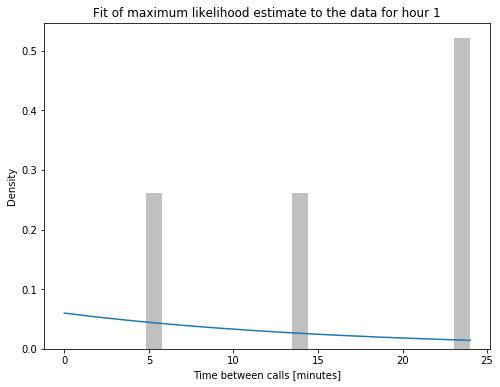

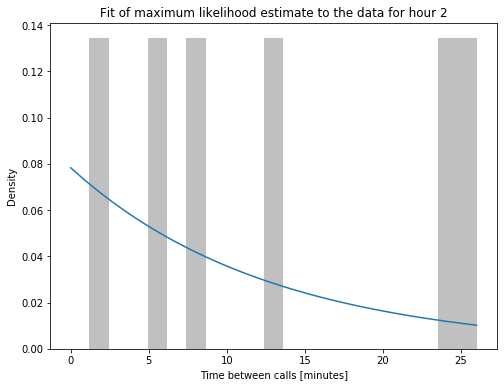

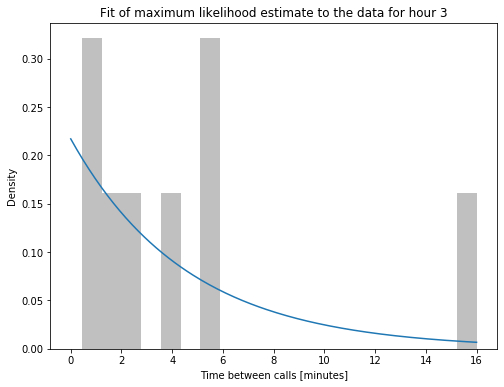

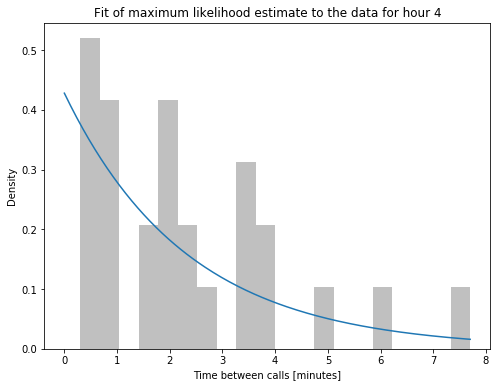

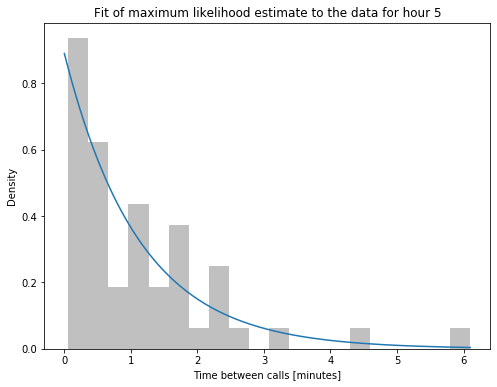

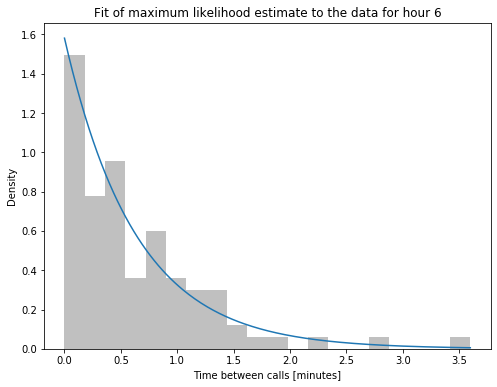

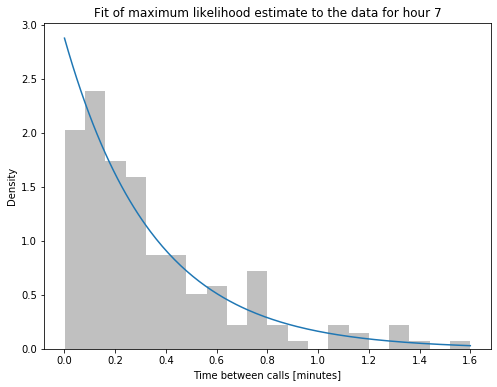

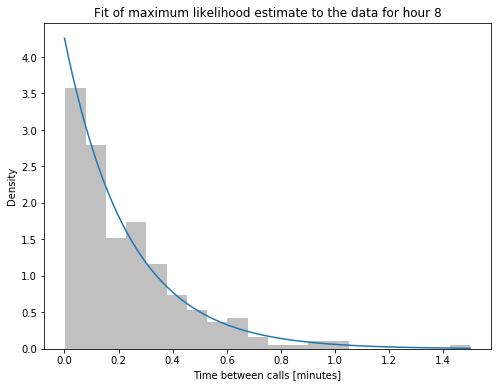

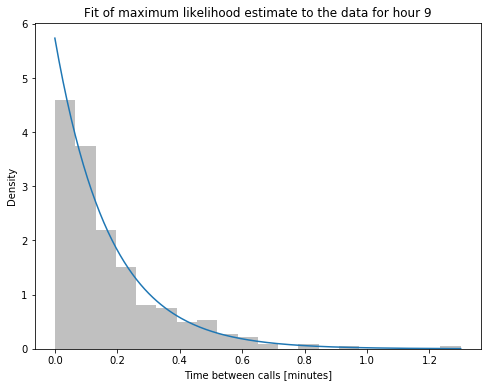

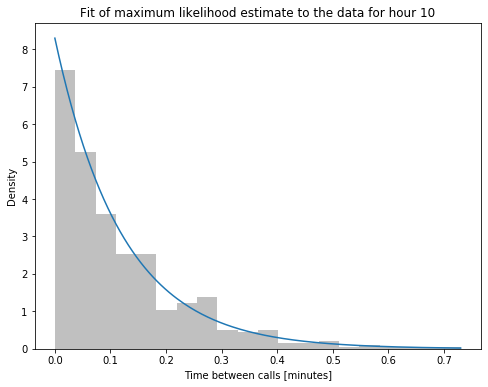

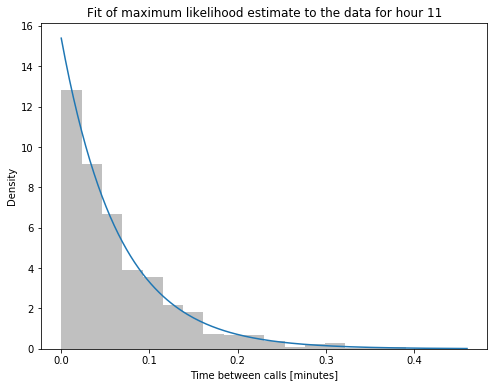

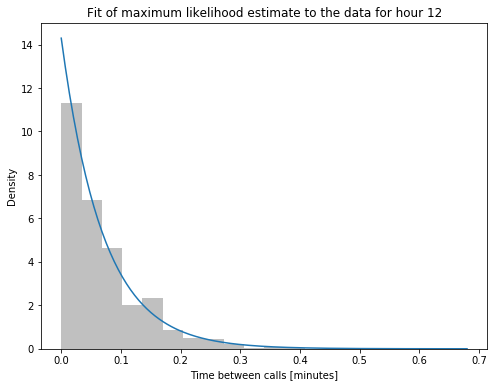

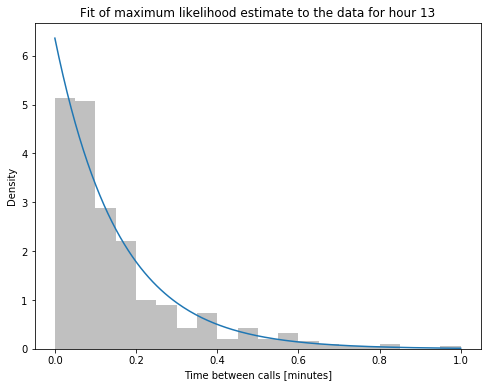

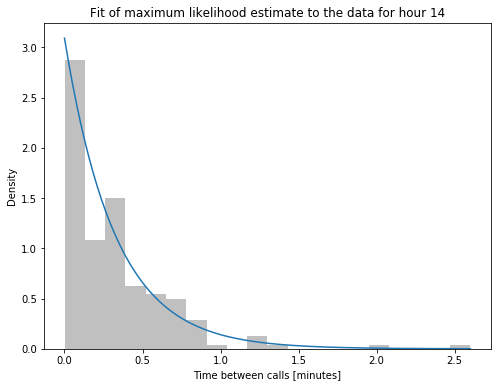

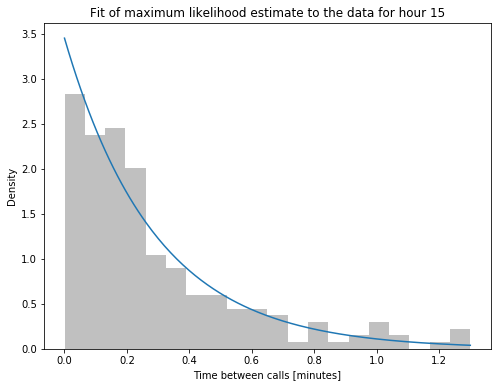

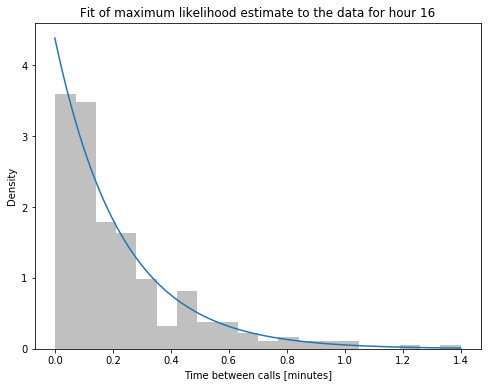

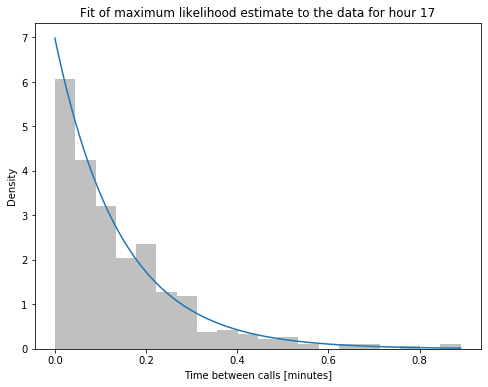

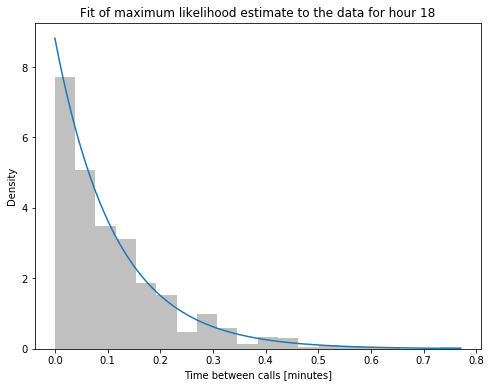

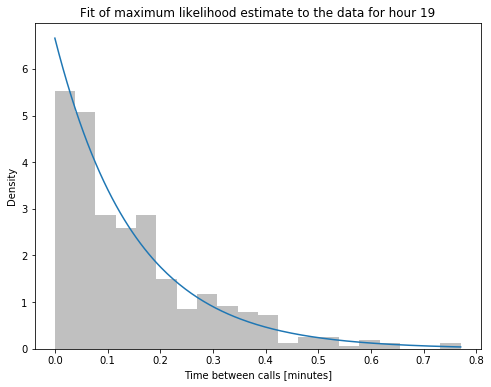

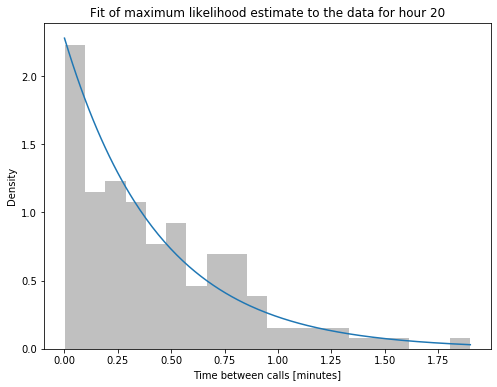

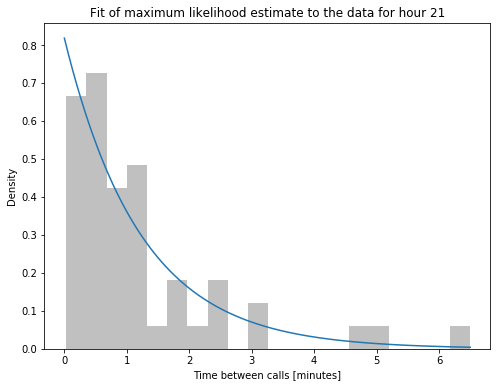

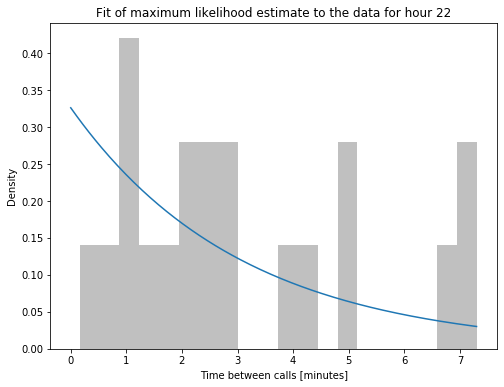

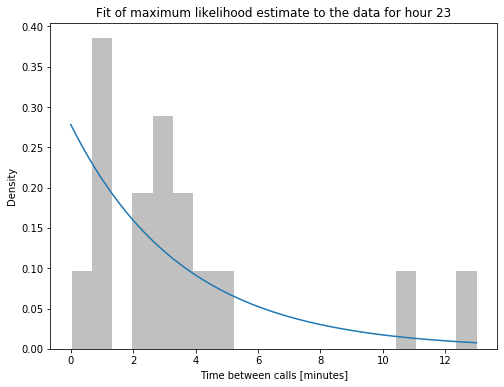

In [105]:
for hour_index in range(0, 24):
    waiting_times_hour = waiting_times_per_hour[hour_index]
    
    # Exponential distribution with maximum likelihood fit to the data
    lambda_ = 1 / np.mean(waiting_times_hour)
    distribution = sts.expon(scale=1/lambda_)

    plt.figure(figsize=(8, 6))
    plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
    x = np.linspace(0, max(waiting_times_hour), 200)
    y = distribution.pdf(x)
    plt.plot(x, y)
    plt.xlabel('Time between calls [minutes]')
    plt.ylabel('Density')
    plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
    plt.show()

The exponential distribution provides an good fit to the data for hours 4 through 21, where there are more data points/ calls recorded. In the small hours of the day, where there is a low number of calls recorded, the histograms are sparse and no clear patterns are discernable in the data. However, there is nothing to suggest that the exponential distribution would be a poor modelling choice for these hours also, given what we know about the distrbution of data within an hour. I make the judgement that it is prudent to procede by modelling the likelihood of every hour with the exponential distribution.

### Compute the call rate mean and 98% confidence interval for each hour

In [65]:
'''
For every hour, calculate the posterior distribution, take the mean and the 98% CI
repreat the procedure we conducted to calculate the posterior distributon for hour 9
'''
#Storage vectors
hourly_median = []
hourly_ci = []

#Lambdas: calls per minute are likely to be in the range(0, 20) 
lambdas = np.linspace(0, 20, 500)[1:]

for hour in waiting_times_per_hour:
    posterior = compute_posterior(lambdas, prior, likelihood, hour)
    
    #Take the mean to be the median
    hourly_median.append(compute_percentile(lambdas, posterior, 0.5))
    
    #Compute confidence intervals
    lower_bound = compute_percentile(lambdas, posterior, 0.01)
    upper_bound = compute_percentile(lambdas, posterior, 0.99)
    hourly_ci.append([lower_bound, upper_bound])

### Plot the Results

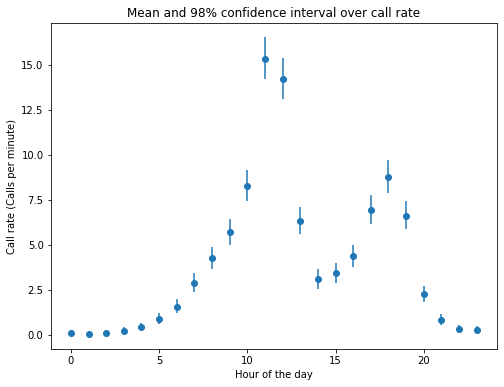

In [101]:
'''
Transform the hourly confidence interval in two ways to give the error intervals:
1. Difference it with the hourly median to get the deviation from the median point
2. Transpose it to put it in the appropriate format for plt.errorbar yerr
'''

plt.figure(figsize=(8, 6))
yerr = [hourly_median-np.asarray(hourly_ci).T[0], np.asarray(hourly_ci).T[1]-hourly_median]
plt.errorbar([x for x in range(24)], hourly_median, yerr=yerr, fmt="o")
plt.xlabel('Hour of the day')
plt.ylabel('Call rate (Calls per minute)')
plt.title('Mean and 98% confidence interval over call rate')
plt.show()

Write a paragraph (100–200 words) to accompany your plot and present your findings to
the client. Carefully summarize how many calls you expect during different parts of the day,
and how much uncertainty there is in your estimates. Remember that the client is not an
expert in statistics, so make it easy for them to understand. You may also make additional
plots to help communicate your results.

### What does this plot say about the number of calls that can be expected at different times during the day?
The above plot shows the call rate, the number of calls per minute, for each hour of the day. Each dot represents the number of calls for that hour, the vertical lines represent the level of uncertainty about the dot: we are virtually certain – we can say it and expect to be right 98 out of 100 times – that the true call rate for every hour is in the range indicated by the line. As you can see, the call rate is close to zero between 22:00 and 04:00. It then increases at a faster and faster rate until it peaks at a rate of approximately 15 calls per minute between 11:00-13:00. There is a second peak around hours 17-19, however the call rate at this peak is lower, at around 7 or 8 calls per minute. The call rate then slows down until the next day. 

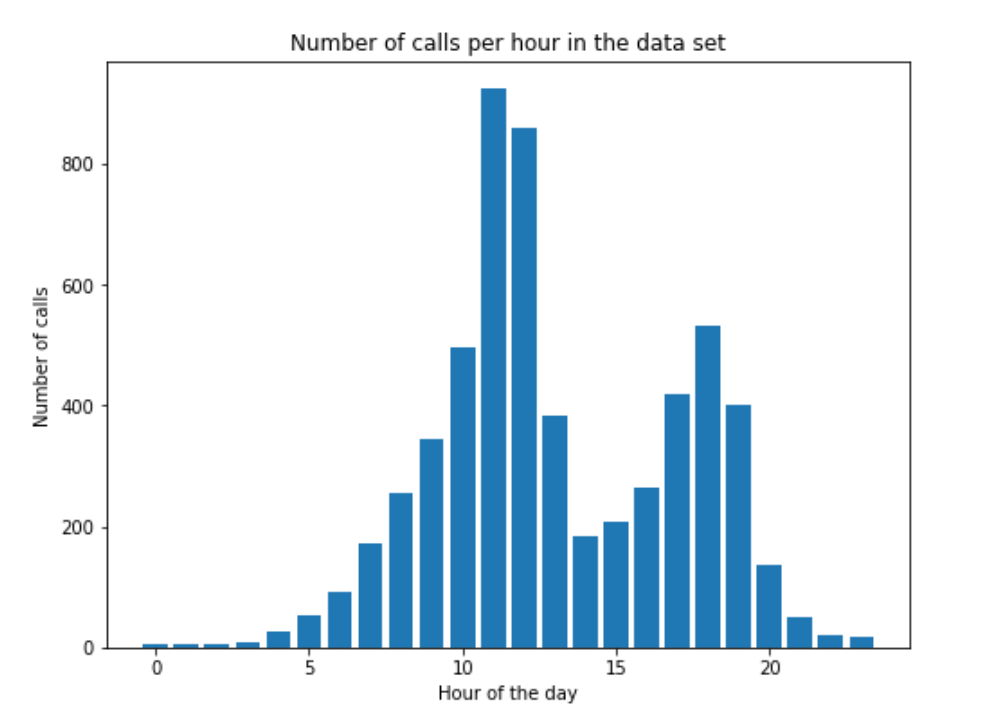
That said, this model is based on the data from a single day. If you compare it to the histogram just showing number of calls per hour, you will find that the shape of the plots to be very similar. Consequently, we must be careful not to overgeneralize these findings: these results tell you something about the number of calls you might expect at different hours of the day for future days only to the extent that the day the model was built on is representative of future days.

If you are looking for a model to help you forecast the number call rate per hour for any given day to optimise workforce decisions, we would be more than happy to help you with that. For that, we would need your calling records for a longer time period – including data on call duration.

# 2. Stretch goal (optional)

1. The purpose of the function is to multiply the prior and likelihood passed as input arguments and to return the posterior as output. Explain how the function achieves this purpose using logarithms.

We use log transformations to maximise numerical precision of the estimates. To understand why, we must understand how numbers are represented in a computer.

Before going there, however, let me define what I mean by precision. For numbers with a large number of decimal values, the higher the number of digits to the right of the decimal sign that we represent, the more precise our representation of the number. E.g. allthough incomplete, 3.141592653589793 is a more precise representation of pi than 3.14. Consequently, calculations performed with the former will be more precise than the same calculations performed with the latter. When the number of operations involved in a calculation is larger, the difference between the ultimate answers becomes greater. Now, onto the representation of numbers in computers:

Numbers are represented as floating points. A floating point consists of a significand a base and an exponent, combined such that an arbitrary number k is expressed as:

k = significand * base ^ exponent

The base is typically 2, but to illustrate the underlying logic I will use base 10. The crucial insight, as pertains to this numerical precision, is that the number of digits in the significand is finite (commonly 52). (Wikipedia, 2019). Denoting the number of digits in the significand as x, then we can see that the number of decimals recorded for a floating point of order 10^y can be expressed as: 

x-y, for 0<=y

x, for 0>y

This means that the smaller the number k, the more decimal points can be recorded. Just to illustrate the principle, image you had only 4 digits to represent a number: A number in the hundreds can be represented with one decimal point precision, whilst a number of the magnitude 10^1 can be expressed with 3 decimal point accuracy. For this reason, smaller numbers are more precise.

Taking the log gives us smaller numbers. The purpose of taking the log, then, is to make large numbers smaller, thus increasing the accuracy with which they can be represented. It is worth adding that the limited number of digits in the exponent and significand place restrictions on the maximum size of numbers that can be represented.
In the extreme, then, using this logarithm method allows one to compute posteriors that otherwise would contain values in the unnormalized posterior too large to represent (leading to all nan outputs, as seen in the example given below).


N.B-: It is okay to solve for the log likelihood instead of the likelihood, as the logarithm is a monotonically increasing function - when x increases, so does log(x), same for decreases. Consequently the value that maximises the log of a function, e.g. the likelihood vs. log likelihood, will be the exact same value that maximises the function.


2. What is the purpose of np.sum() in line 4?


When we take the logarithm of an expression, the Logarithm Product rule stipulates that terms that originally were to be multiplied should now be added. As we are taking the logarithm of the likelihood, we sum the values corresponding to each value of the parameter given the data, instead of multiplying as we would normally(otherwise) do.

This is also why we add the log likelihood and the prior, rather than multiplying them, on line 6.

3. Explain why the maximum of the unnormalized log posterior is subtracted in line 7.


This is yet another trick to take advantage of the observation that smaller numbers can be expressed with greater decimal precision.

When we subtract the maximum value of the unnormalized log posterior from every value in the unnormalized log posterior, all values become negative (except the maximum, which becomes 0). This means that when we exponentiate the unnormalized log posterior, the maximium value of the unnormalized posterior becomes 1=exp(0)). All other numbers in the unnormalized posterior will lie between 0 and 1, and can thus be expressed with maximal decimal precision – a zero to the left of the decimal point, all other digits in the significand will fall to the right of the decimal point.
Consider instead what might happen if we did not do this, we would be exponentiating potentially large numbers, into even larger numbers, leaving fewer digits for decimal values, leading to lower decimal precision and ultimately less accurate calculations.

4. Why do we still have to divided by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7?

Just because we subtracted the max value, such that all values now lie between 0 and 1 does not imply that the distribution is a valid probability distribution: it must also integrate to 1. It is for this reason that we normalize it by dividing by the area: k/k = 1. In the edge case where the unnormalized posterior already integrated to 1, dividing by the area, 1, will have no effect on the distribution (unnormalized posterior = posterior).

5. Create an example where not taking logarithms would cause a problem. Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs. Show all your code and visualize your results on one or more plots.

We expect the benefits of taking the log to be particularly pronounced when we dealing with large vales. We thus expect problems to arise in just such situations. Large values will occur if we start from large values, then multiply and exponentiate them. To simulate this, without going through the hassle choosing approprate likelihoods and priors etc again, I will modify the dataset we already have access to. Specifically, I will take one hour, hour 9, and sample from the exponential distribution we fit to it and then multiply every sample by a large constant, to simulate a dataset with large observation values.

In [199]:
def make_large_data():
    #Fit exponential distribution for hour 9
    waiting_times_hour = waiting_times_per_hour[9]
    lambda_ = 1 / np.mean(waiting_times_hour)
    distribution = sts.expon(scale=1/lambda_)
        
    #Draw 1000 samples, multiply each by the multiplying constant to enlarge
    multiplying_constant = 10**2
    sample = distribution.rvs(size = 50) * multiplying_constant
    return sample

In [200]:
large_data = make_large_data()

In [201]:
def compute_posterior_no_log(parameter_values, prior, likelihood, data):
    prior = prior(parameter_values)
    likelihood = np.array([
        np.prod(likelihood(param, data))
        for param in parameter_values])
    unnormalized_posterior = prior * likelihood

    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

In [202]:
compute_posterior_no_log(lambdas, prior, likelihood, large_data)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, na

In [203]:
def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

compute_posterior(lambdas, prior, likelihood, large_data)

/Users/oscarengelbrektson/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


array([1.10888616e+002, 1.36583838e-004, 1.65613171e-010, 1.97792101e-016,
       2.32790287e-022, 2.70131206e-028, 3.09200620e-034, 3.49263810e-040,
       3.89490832e-046, 4.28988375e-052, 4.66836284e-058, 5.02126430e-064,
       5.34001472e-070, 5.61691080e-076, 5.84543458e-082, 6.02050401e-088,
       6.13864643e-094, 6.19808858e-100, 6.19876232e-106, 6.14223126e-112,
       6.03154762e-118, 5.87105268e-124, 5.66613593e-130, 5.42296941e-136,
       5.14823319e-142, 4.84884664e-148, 4.53171813e-154, 4.20352311e-160,
       3.87051758e-166, 3.53839103e-172, 3.21216037e-178, 2.89610363e-184,
       2.59373071e-190, 2.30778673e-196, 2.04028258e-202, 1.79254706e-208,
       1.56529465e-214, 1.35870343e-220, 1.17249815e-226, 1.00603405e-232,
       8.58378053e-239, 7.28384492e-245, 6.14763562e-251, 5.16141242e-257,
       4.31110155e-263, 3.58271308e-269, 2.96267082e-275, 2.43806115e-281,
       1.99680938e-287, 1.62779331e-293, 1.32090389e-299, 1.06706302e-305,
       8.58207563e-312, 6

As predicted, the function that computes the posterior fails and produces on nan outputs as the unnormalized posterior contains values that are too large to be represented as floating points, whilst the log-version works.